In [1]:
import numpy as np
import matplotlib

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
from scipy.misc import derivative
from scipy.integrate import solve_bvp
from functools import partial
from scipy import special as sp
from scipy import stats
import plasmapy.mathematics
import scipy.optimize as op

from scipy import fftpack
from scipy import integrate
from scipy import signal

%config InlineBackend.figure_format = 'svg'

In [58]:
tem = 1
L = 100
vmax = 10  # 10 * np.sqrt(tem)
nx = 201
nv = 251
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)
dt = 0.01
max_steps  = 100000
data_steps = 10000
data_num = int(max_steps/data_steps)
uae = 0.55
uai = 0.5
kappa = 0.0

path = './data/'

m=1
n=1
q=1
v_th = np.sqrt(2*tem)
l_D = np.sqrt( tem) # $\lambda_D^2$
w_pe = 1
print("data_num = ",data_num)

data_num =  10


In [59]:
k = 1*2*np.pi/L
def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]
#kvec = np.arange(.1,1.2,0.1)
print("k = ",k)
s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
v_p = s.x[0]/k
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])
print("v_p = ",v_p)
print("t_Bi = ", abs(1/np.sqrt(q*abs(uae-uai))))
#print("t_Bf = ", abs(1/np.sqrt(q*abs(ff(L/2)-uai))))
print("t_L = ", abs(1/s.x[1]))
print('limited time=',2*np.pi/k/dv)
print('real time = ', max_steps*dt)

k =  0.06283185307179587
w_r =  1.00595156956885
w_i =  -7.463486778040684e-14
v_p =  16.01021648079331
t_Bi =  4.472135954999577
t_L =  13398563295405.479
limited time= 1249.9999999999998
real time =  1000.0


## 理论预测

In [61]:
def fm(v, t):
    r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    return r
def fk(v, t, kappa):
    if(kappa == 0):
        r = fm(v, t)
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r
def ue(x):
    r = 1.+uae*np.cos(k*x)
    return r
def ui(x):
    r = 1.+uai*np.cos(k*x)
    return r
def fkt(v, x, kappa):
    t = tem*ue(x)
    if(kappa == 0):
        r = fm(v, t)
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r
#theoretical energy
def nphi(x):
    #average potential (/L)
    phi = -( q*(uae-uai) )/ (k**2)*np.cos(k*x)/L
    return (ui(x)-ue(x) )*q*phi
ek_theo = 0.5*tem
ep_theo = 0.5*integrate.quad(nphi,0,L)[0]
einit_theo=ek_theo+ep_theo

print("Ek = ",ek_theo)
print("Ep = ",ep_theo)
print("Etot = ",einit_theo)
def entropy(x,v):
    ufv = fk(v, tem,kappa)*ue(x)/L
    if (ufv==0.0):
        r = 0.0
    else:
        r = -ufv * np.log(ufv)
    r = ufv**2
    return r
options = {'limit':50000}
entropyt_int_res = integrate.nquad(entropy,[[0,L],[-np.inf,np.inf]], opts=[options,options])
#entropyt_int_res = integrate.nquad(entropy,[[0,L],[-vmax,vmax]], opts=[options,options])
entropyt=entropyt_int_res[0]
print(entropyt)
def ug(x):
    r = (1. + uai * np.cos(k*x)) #/ (2*1.*a)
    return r

def ug_dev(x):
    r = -uai*k*np.sin(k*x)#/ 2. / a
    return r

def eq4U(x,yy,p):
    kappa,t=p
    dy, y = yy
    k_factor = (kappa+2) / (kappa+1)
    dy2y = (dy**2) / y
    ddy = k_factor * dy2y + (kappa+1) / (kappa) * (y**k_factor) * ( y-ui(x) ) / t * n * (q**2)
    return np.vstack((ddy, dy))

def bc4U(ya, yb):
    return np.array([ya[0]-yb[0],ya[1]-yb[1]])

xi = np.linspace(0, L, num=5000, dtype='complex',endpoint=False)
yguess = np.array([ug_dev(xi), ui(xi)])

def eq4para(x,energy,entropy):
    kp,tp = x
    sol4ode = solve_bvp(partial(eq4U, p=x), bc4U, xi,
                        yguess, tol=1e-13, max_nodes=50000)

    def ff(x):
        return sol4ode.sol(x)[1]
    def ff_r(x):
        return ff(x).real
    def ff_i(x):
        return ff(x).imag

    def ff_inti(x):
        r = ff(x)**(kp/(kp+1))
        return r
    def ff_inti_r(x):
        return ff_inti(x).real
    def ff_inti_i(x):
        return ff_inti(x).imag
        
    def ff_intii(x):
        r = ui(x) * (ff(x) ** (-1.0/(kp+1)))
        return r
    def ff_intii_r(x):
        return ff_intii(x).real
    def ff_intii_i(x):
        return ff_intii(x).imag
    
    def ff_intiii(x):
        r = ff(x)**(-1./(kp+1))
        return r
    def ff_intiii_r(x):
        return ff_intiii(x).real
    def ff_intiii_i(x):
        return ff_intiii(x).imag
    
    def entropy_pred(x, v):
        U_x = ff(x)
        
        if(kp==0):
            t_x = tp
            tempf = U_x * fm(v, t_x)/L+0j
        else:
            t_x = tp * U_x ** (-1./(kp+1))
            tempf = U_x * fk(v, t_x, kp)/L+0j
        if (tempf == 0.0+0.0j):
            r = 0.0
        else:
            r = -tempf * np.log(tempf)
        r = tempf**2
        return r
    def entropy_pred_r(x,v):
        return entropy_pred(x,v).real
    def entropy_pred_i(x,v):
        return entropy_pred(x,v).imag
    entropy_pred_int_r = integrate.dblquad(
        entropy_pred_r, -np.inf, np.inf,  0,  L, epsrel=1e-10)
    entropy_pred_int_i = integrate.dblquad(
        entropy_pred_i, -np.inf, np.inf,  0,  L, epsrel=1e-10)
    entropyp = entropy_pred_int_r[0] + 1j * entropy_pred_int_i[0]

    int_ff_r = integrate.quad(ff_r, 0, L, epsrel=1e-10)[0]-1.0
    int_ff_i = integrate.quad(ff_i, 0, L, epsrel=1e-10)[0]-1.0
    int_ff = int_ff_r + 1j * int_ff_i
    
    int_i_r = integrate.quad(ff_inti_r, 0, L, epsrel=1e-10)[0]
    int_i_i = integrate.quad(ff_inti_i, 0, L, epsrel=1e-10)[0]
    int_i = int_i_r + 1j * int_i_i

    int_ii_r = integrate.quad(ff_intii_r, 0, L, epsrel=1e-10)[0]
    int_ii_i = integrate.quad(ff_intii_i, 0, L, epsrel=1e-10)[0]
    int_ii = int_ii_r + 1j * int_ii_i

    int_iii_r = integrate.quad(ff_intiii_r, 0, L, epsrel=1e-10)[0]
    int_iii_i = integrate.quad(ff_intiii_i, 0, L, epsrel=1e-10)[0] 
    int_iii = (int_iii_r + 1j * int_iii_i) * int_ff

    eq1 = ((energy*2)*L - tp * (1+kp) * int_i + tp * kp * int_ii)/(energy*2)/L
    eq2 = (entropyp-entropy)/entropy

    return eq1.real,eq2.real

Ek =  0.5
Ep =  0.15831434944115302
Etot =  0.658314349441153
0.0032476162902990106


In [62]:
para_guess = [0.14708099,2.83689694]
#para_guess = [3.20396257,1.02909498]
#para_guess = [0.014708099,28.3689694]
sol_para = op.root(partial(eq4para,energy=einit_theo,entropy=entropyt), para_guess, method='hybr')
#sol_para = op.root(partial(eq4para,energy=einit_theo,entropy=entropy_sim), para_guess, method='hybr')
para = sol_para.x

print(para)
print(sol_para.fun,sol_para.success)

[1.46309385 1.33734874]
[8.63469236e-16 8.10576940e-14] True


In [63]:
#para = [0.67889345,1.37987956]#for S_BG
#para= [1.606,1.374]#for S_2
#para = [1.1,1.2]
yguess = np.array([ug_dev(x), ui(x)])
sol = solve_bvp(partial(eq4U,p=para), bc4U, x, yguess,tol=1e-13,max_nodes=50000)
def fx_theo(x):
    return sol.sol(x)[1].real
def t_theo(x):
    return para[1]*(fx_theo(x).real)**(-1.0/(para[0]+1))
def phi_theo(x):
    return -para[0]*t_theo(x)/q

## 函数定义&数据读取

In [64]:
def fm(v, t):
    r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    return r
def fk(v, t, kappa):
    if(kappa == 0):
        r = fm(v, t)
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r
def fr(v,t):
    r = (-2+np.sqrt(2))*np.sqrt(np.pi*t)*(sp.zetac(0.5)+1) / ( np.exp(v**2/2/t)+1 )
    return r
def ue(x):
    r = 1.+uae*np.cos(2.*np.pi*x/L)
    return r
def ui(x):
    r = 1.+uai*np.cos(2.*np.pi*x/L)
    return r
def fk_xv(x,v,k,t):
    if(k==0):
        s = fx_theo(x)*np.sqrt( fx_theo(x)**( 1./(k+1) ) / (2*np.pi*t) )/L
        m = np.exp(-v**2 / (2*t) * fx_theo(x)**(1./(k+1)))
        r = s*m
    else:
        s = fx_theo(x)*np.sqrt( fx_theo(x)**( 1./(k+1) ) / (2*np.pi*t*k) )/L
        frac = sp.gamma(k+1.5) / sp.gamma(k+1)
        m = ( 1+ (v)**2 / (k*2*t) * fx_theo(x)**(1./(k+1)) )**(-k-1.5)
        r = s*frac*m
    return r.real
def fk_v_nonvec(vv,kk,tt):
    r = integrate.quad(partial(fk_xv,v=vv,k=kk,t=tt),0,L)[0]
    return r
fk_v = np.vectorize(fk_v_nonvec)

In [65]:
progesses = np.arange(0,data_num,1)

f = []
phi = []

for progess in progesses:
    f_temp = np.loadtxt(os.path.join(path,"data"+str(progess)))
    f.append(f_temp)
    phi_temp = np.loadtxt(os.path.join(path,"phi"+str(progess)))
    phi.append(phi_temp)

## 定态展示

In [66]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path, "pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path, "kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

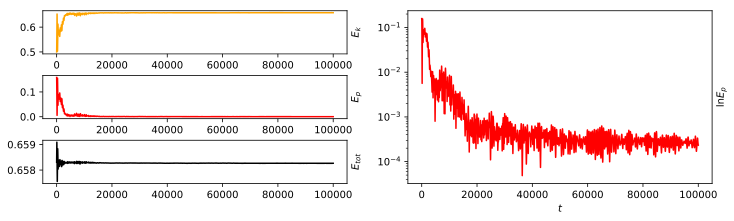

In [67]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

In [68]:
ek_sim = dataek[max_steps-1]
ep_sim = dataep[max_steps-1]
energy_sim=dataet[max_steps-1]
print("Ek = ",ek_sim)
print("Ep = ",ep_sim)
print("Etot = ",energy_sim)

def entropy_calc(f):
    s = 0.0
    for i in f.flatten():
        #if (i<=0):
            #s += 0.0
        #else:
            #s += -i/L * np.log(i/L)
        s += (i/L)**2
    return s*dx*dv

entropy_sim = entropy_calc(f[data_num-1])
print('S= ',entropy_sim)
print('E_erro=', (einit_theo-energy_sim)/einit_theo*100, "%")
print('S_erro=', (entropyt-entropy_sim)/entropyt*100, "%")

Ek =  0.6580331937069
Ep =  0.0002326878681367
Etot =  0.658265881575
S=  0.003255921354138559
E_erro= 0.007362419821795442 %
S_erro= -0.25572798930577156 %


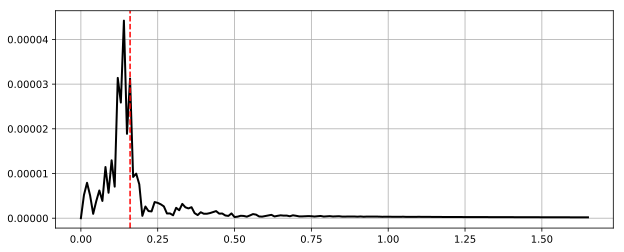

In [69]:
n = 10000
y_k = fftpack.fft(dataep[max_steps-1-n:max_steps-1])
x_k = fftpack.fftfreq(len(y_k),dt)
y_k_abs = np.abs(y_k)
y_k_phi = np.angle(y_k)
y_k_abs[0] = 0

plt.figure(figsize=(10,4))
    
ax2 = plt.subplot()
k_plot_scale=n//60
ax2.plot(x_k[0:k_plot_scale],2*y_k_abs[0:k_plot_scale]/n,color='black',lw=2)
ax2.axvline(s.x[0]/2/np.pi,color='red',ls='--')

ax2.grid()

### 分布函数fx fv

In [70]:
fx0 = np.sum(f[0],axis=1)*dv
fv0 = np.sum(f[0],axis=0)*dx/L
fx = np.sum(f[data_num-1],axis=1)*dv
fv = np.sum(f[data_num-1],axis=0)*dx/L
T0 = np.sum(v**2*f[0],axis=1)*dv/fx0
T = np.sum(v**2*f[data_num-1],axis=1)*dv/fx

#T_times = []
#for i in range(data_num-1):
#    f_temp = f[data_num-1-i]
#    fx_temp = np.sum(f_temp,axis=1)*dv
#    T_temp = np.sum(v**2*f_temp,axis=1)*dv/fx_temp
#    T_times.append(T_temp)
#T = np.mean(T_times,axis=0)

In [71]:
grad_p = np.diff(fx*T)/dx
grad_p = np.append(grad_p, grad_p[0])
grad_phi = np.diff(phi[data_num-1])/dx
grad_phi = np.append(grad_phi, grad_phi[0])

grad_p_theo = np.diff(fx_theo(x)*t_theo(x))/dx
grad_p_theo = np.append(grad_p_theo, grad_p_theo[0])
grad_phi_theo = np.diff(phi_theo(x))/dx
grad_phi_theo = np.append(grad_phi_theo,grad_phi_theo[0])

In [72]:
chi_err_f = np.sum(
    ( (fk_v(v, para[0], para[1])-fv) )**2/fk_v(v,para[0], para[1]) * dv)
print(chi_err_f)

0.01700006989348759


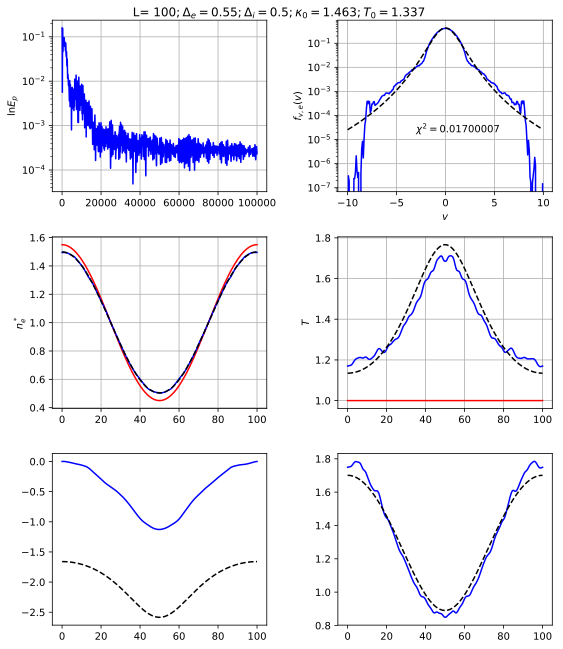

In [73]:
fig = plt.figure(figsize=(8, 9))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataep, color='blue')
ax1.set_ylabel(r'$\ln E_p$')
ax1.set_yscale('log')
ax1.grid()

ax2 = plt.subplot2grid((3, 2), (0, 1))
vstart = -vmax
vend = vmax
nvs = int((vstart + vmax) / dv)
nve = int((vend + vmax) / dv)
#ax2.plot(v[nvs:nve], fv0[nvs:nve], color='red', label='intial')
ax2.plot(v[nvs:nve], fv[nvs:nve], color='blue', label='simulation')
ax2.plot(v[nvs:nve], fk_v(v[nvs:nve], para[0], para[1]),
         '--', color='black', label='theo')
ax2.set_xlabel(r'$v$')
ax2.set_ylabel(r'$f_{v,e}(v)$')
ax2.text(-3,2e-5,r'$\chi^2 = $'+('%.8f' % chi_err_f))
ax2.set_yscale('log')
ax2.grid()

ax3 = plt.subplot2grid((3, 2), (1, 0))
ax3.plot(x, fx0, color='r', label='initial')
ax3.plot(x, fx, color='blue', label='final')
ax3.plot(x, fx_theo(x), '--', color='black', label='theo')
ax3.set_ylabel(r'$n_e^*$')
ax3.grid()

ax4 = plt.subplot2grid((3, 2), (1, 1))
ax4.plot(x, T0, color='r', label='initial')
ax4.plot(x, T, color='blue', label='final')
ax4.plot(x, t_theo(x), '--', color='black', label='theo')
ax4.set_ylabel(r'$T$')
ax4.grid()

ax5 = plt.subplot2grid((3, 2), (2, 0))
ax5.plot(x, phi[data_num-1],color='blue')
ax5.plot(x, phi_theo(x),'--',color='black')

ax6 = plt.subplot2grid((3, 2), (2, 1))
ax6.plot(x, fx*T,color='blue')
ax6.plot(x, fx_theo(x)*t_theo(x),'--',color='black')

title_text = "L= " + str(L) + r"$; \Delta_e= $" + str(uae) + r"$; \Delta_i= $" + \
    str(uai) + r"$; \kappa_0= $" + str(round(para[0],3)) + r"$; T_0= $" + str(round(para[1],3))
fig.suptitle(title_text,va='bottom')
plt.tight_layout()
#plt.savefig("./results/formation_kappa_distribution/7_S2.png", dpi=600,bbox_inches = 'tight')
plt.show()

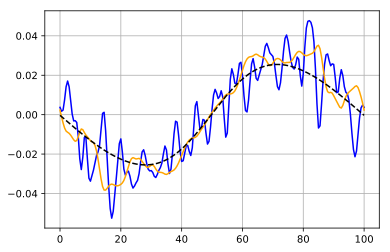

In [74]:
plt.plot(x,grad_p,color='blue')
plt.plot(x,fx*grad_phi,color='orange')
plt.plot(x,grad_p_theo,linestyle='--',color='black')
#plt.plot(x,fx_theo(x)*grad_phi_theo,linestyle='--',color='red')
plt.grid()
plt.show()

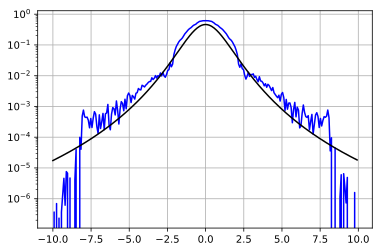

In [75]:
plt.plot(v[nvs:nve],f[data_num-1][0,nvs:nve],color='blue',label='sim')
plt.plot(v[nvs:nve],fk(v[nvs:nve],t_theo(0),para[0]),color='black')
plt.yscale('log')
plt.grid()
plt.show()

LinregressResult(slope=-3.02007972280956, intercept=0.8697917615169708, rvalue=-0.9905557383124832, pvalue=1.0794734554293011e-173, stderr=0.029633580501596198)


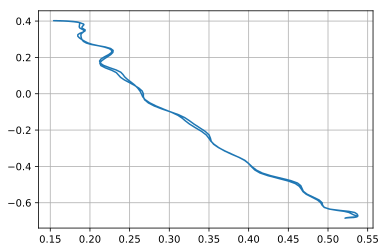

In [76]:
print(stats.linregress(np.log(T),np.log(fx)))
plt.plot(np.log(T),np.log(fx))
plt.grid()
plt.show()